# Toy example for Supervised Learning: A Practical Guide to Linear and non linear Regression

### Introduction 

Understanding the underlying patterns in data through supervised learning is crucial. This tutorial try to go through a toy example of analysing a mixed model containing both linear and non linear features and trying to create a regression mode, a more advanced technique that handles both linear and non-linear relationships within datasets.
This tutorial was done part of a Machine Learning and Data Science course taught by O. Deniz Akyildiz at Imperial College London, will guide you through understanding and implementing these concepts using Python and `scikit-learn`.

## 1. Linear regression
We start our work by simulating a toy datasets to be used for our modelling. For the purpose of this tutorial,  we provide here 2 examples of already simulated data for our model :
$$Y_i = X^T_i β + g(T_i) + \epsilon_i$$
- `data1` simulated in a sparse way, where the vector $\beta$ will have only 10% non-zero entries out of the 19 predictors, reflecting a real-world scenario where we have many features but only a subset of features significantly impacts the response variable. `T_i` in this dataset will represent the time.
- `data2` is also simulated in a sparse way and with a true non-linear function `g` with a periodic behavior. We will need for this dataset to structure our train/test split to have first half of the data in the train set and the second half in the test set (to be able to test the extrapolation capabilities of our model ) 

We start by importing the list of needed library. We need a version of sklearn that is >= 1.4

In [1]:
# Import the libraries that will be used in our project
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn
if sklearn.__version__ <= '1.4':
    print('Error: Your version of sklearn is not greater than 1.4. Please update sklearn to continue.')
else:
    print('Your version of sklearn is greater than 1.4. You may proceed.')
import zipfile
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error,mean_absolute_error



Your version of sklearn is greater than 1.4. You may proceed.


We start first by loading our data and plotting the output `y` to see its behavior in relation to `T`

In [2]:
def generate_sparse_dataset(n_samples, n_features=19, influence_ratio=0.2):
    # Number of features that actually influence the output
    n_influential = int(np.ceil(n_features * influence_ratio))
    
    # Generate random data for n_samples and n_features
    X = np.random.randn(n_samples, n_features)
    
    # Randomly select a few features that will influence the output
    influential_indices = np.random.choice(n_features, n_influential, replace=False)
    
    # Generate random coefficients for the influential features
    coefficients = np.random.randn(n_influential)
    
    # Calculate the output y, only influenced by selected features
    y = np.dot(X[:, influential_indices], coefficients) + np.random.randn(n_samples) * 0.1  # Adding some noise
    
    return X, y, influential_indices, coefficients

# Generating synthetic data
n_samples = 1500
T = np.linspace(0, 1000, n_samples)
X, y1_1, influential_indices, coefficients = generate_sparse_dataset(n_samples)

# If you want to see the dataset in a more visual way using pandas:
df = pd.DataFrame(X, columns=[f'Feature_{i+1}' for i in range(19)])
df['Output'] = y1_1
print("Influential features:", influential_indices)

y2_1 = 100 + 0.001*(T + (T-500)**2) # quadratic non-linear component
y2_2 =  np.cos(T/15)  # sinusoidal non-linear component
y1 = pd.DataFrame(10*y1_1 + y2_1)
y2 = pd.DataFrame(10*y1_1 + 75*y2_2)

# Combining our features
X = pd.DataFrame(X)
T = pd.DataFrame(T)
XT1_combined = pd.concat([X, T], axis=1)
XT2_combined = pd.concat([X, T], axis=1)

# Splitting the datasets into training and testing sets
XT1_train, XT1_test, y1_train, y1_test = train_test_split(XT1_combined, y1, test_size=0.2, random_state=42)

# For Dataset 2, we split based on the time order for extrapolation
split_index = len(X) // 2
XT2_train, XT2_test = XT2_combined[:split_index], XT2_combined[split_index:]
y2_train, y2_test = y2[:split_index], y2[split_index:]
X1 = X2 = X
T1 = T2 = T


Influential features: [ 3 16 13 12]


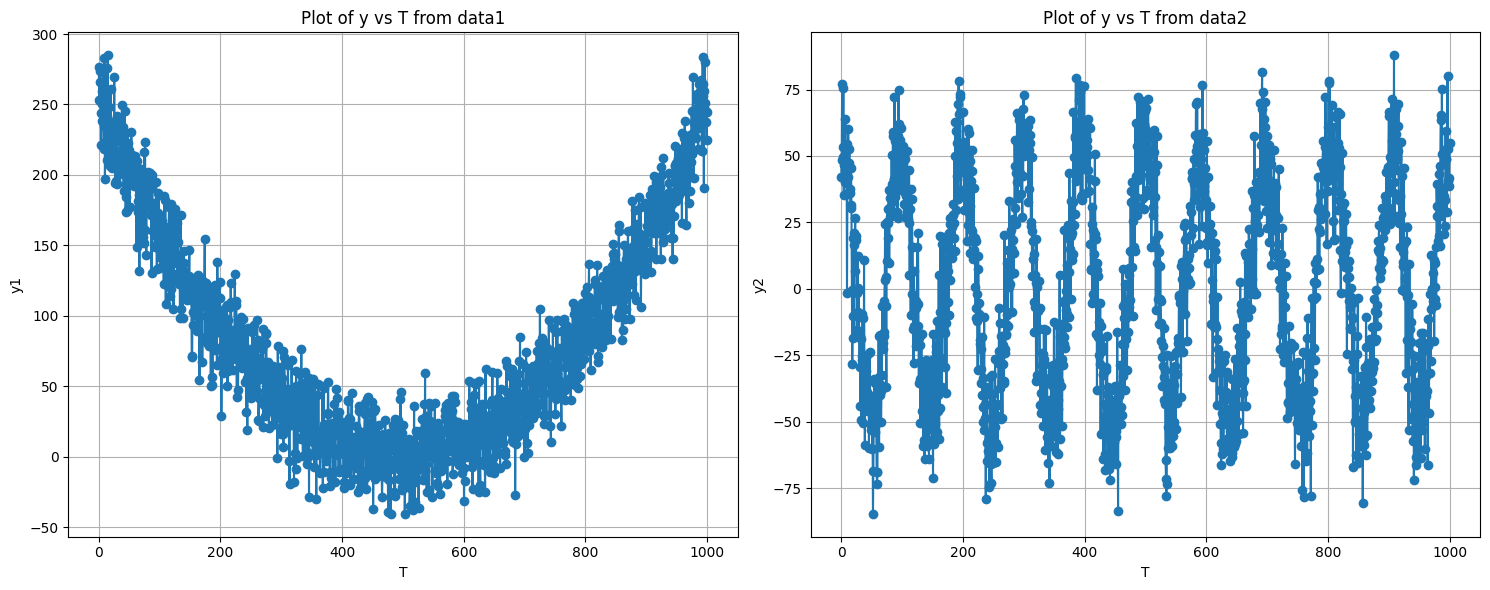

In [27]:

# Plotting
plt.figure(figsize=[15,6])

# Plot for data1
plt.subplot(1, 2, 1)
plt.plot(T, y1, 'o-') # Modify if different data structure
plt.title('Plot of y vs T from data1')
plt.xlabel('T')
plt.ylabel('y1')
plt.grid(True)

# Plot for data2
plt.subplot(1, 2, 2)
plt.plot(T, y2, 'o-') # Modify if different data structure
plt.title('Plot of y vs T from data2')
plt.xlabel('T')
plt.ylabel('y2')
plt.grid(True)

plt.tight_layout()
plt.show()

Otherwie if we need to load from an external file :

In [2]:
# Load the data from the zip file
with zipfile.ZipFile('data1.zip', 'r') as z:
    with z.open('data1/T.csv') as f:
        T1 = pd.read_csv(f,header = None)
    with z.open('data1/X.csv') as f:  # If you need to use X for something
        X1 = pd.read_csv(f, header = None)
    with z.open('data1/y.csv') as f:
        y1 = pd.read_csv(f,header = None)

# Load the data from the zip file
with zipfile.ZipFile('data2.zip', 'r') as z:
    with z.open('data2/T.csv') as f:
        T2 = pd.read_csv(f,header = None)
    with z.open('data2/X.csv') as f:  # If you need to use X for something
        X2 = pd.read_csv(f,header = None)
    with z.open('data2/y.csv') as f:
        y2 = pd.read_csv(f,header = None)
# Combining our features
XT1_combined = pd.concat([X1, T1], axis=1)
XT2_combined = pd.concat([X2, T2], axis=1)

# Splitting the datasets into training and testing sets
XT1_train, XT1_test, y1_train, y1_test = train_test_split(XT1_combined, y1, test_size=0.2, random_state=42)

# For Dataset 2, we split based on the time order for extrapolation
split_index = len(X2) // 2
XT2_train, XT2_test = XT2_combined[:split_index], XT2_combined[split_index:]
y2_train, y2_test = y2[:split_index], y2[split_index:]


As a first attempt, we will try to have a naive and simple linear analysis. This will be our base for comparaison with our model.  We will do the following steps :
- we start by combining `Xi` and `Ti` (combining input features and the time variable)
- Splits the datasets into training and testing sets, with `data1` being split randomly and data2 split sequentially to maintain the time series nature
- We fits the linear regression model to the training data using the `LinearRegressino()` funciton from `sklearn` library
- We used our fitted model to predict the outcomes for the testing set
- then we evaluate the model using $R^2$ and RMSE (Root Mean Squared Error) 
- we will also plot residuals vs. fitted, Q-Q plot, and scale-location plot to have a visualisation on how our naive model does on our data

We combine our input data into one dataframe that we will use as input for our model in all this tutorial (`XT1_combined` and `XT2_combined`).
Then we will split our data into train/test datasets.

In [3]:
# Combining our features
XT1_combined = pd.concat([X1, T1], axis=1)
XT2_combined = pd.concat([X2, T2], axis=1)

# Splitting the datasets into training and testing sets
XT1_train, XT1_test, y1_train, y1_test = train_test_split(XT1_combined, y1, test_size=0.2, random_state=42)

# For Dataset 2, we split based on the time order for extrapolation
split_index = len(X2) // 2
XT2_train, XT2_test = XT2_combined[:split_index], XT2_combined[split_index:]
y2_train, y2_test = y2[:split_index], y2[split_index:]



The first regression using a linear regression on the combined input features

In [4]:

# Define the pipelines for both datasets
pipeline1 = Pipeline([
    ('scaler', StandardScaler()),  # First, scale the data
    ('regressor', LinearRegression())  # Then, apply linear regression
])
pipeline2 = Pipeline([
    ('scaler', StandardScaler()),  # First, scale the data
    ('regressor', LinearRegression())  # Then, apply linear regression
])

# Perform linear regression analysison data1  using the pipeline1 and on data2 using the pipeline2
pipeline1.fit(XT1_train, y1_train)
pipeline2.fit(XT2_train, y2_train)

# Make predictions
y1_pred = pipeline1.predict(XT1_test)
y2_pred = pipeline2.predict(XT2_test)



# Evaluate the models
def evaluate_model(y_test,y_pred, title):
    print(f"{title}")
    print(f"    R^2 Score: {r2_score(y_test, y_pred):.2f}")
    print(f"    MSE: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"    RMSE: {root_mean_squared_error(y_test, y_pred):.2f}")
    print(f"    MAE: {mean_absolute_error(y_test, y_pred):.2f}")

          


evaluate_model(y1_test,y1_pred,"Dataset 1 - Metrics for a simpleLinear Regression")
evaluate_model(y2_test,y2_pred,"Dataset 2 - Metrics for a simpleLinear Regression")





Dataset 1 - Metrics for a simpleLinear Regression
    R^2 Score: -0.02
    MSE: 5191.02
    RMSE: 72.05
    MAE: 60.45
Dataset 2 - Metrics for a simpleLinear Regression
    R^2 Score: 0.07
    MSE: 1395.39
    RMSE: 37.35
    MAE: 33.45


From the results given on our fitting model using a naive linear regression, we can see that :
- **$R^2$ Score** : for both dataset 1 and 2, we have either negative (-0.02) or very low (0.07) number that are almost zeros. This suggest that the model does not explain or capture any of the variance in the response variable. For the negative score, it is even doing worst than a simple horizontal line at the mean of the response (case of dataset 1)
- **RMSE** : Similarly, the values of RMSE are high for both cases (72.05 and 37.35) which indicative of a poor fit

We can extend this exploration by trying to plot some observation of the residuals to confirm our evaluation of our model.

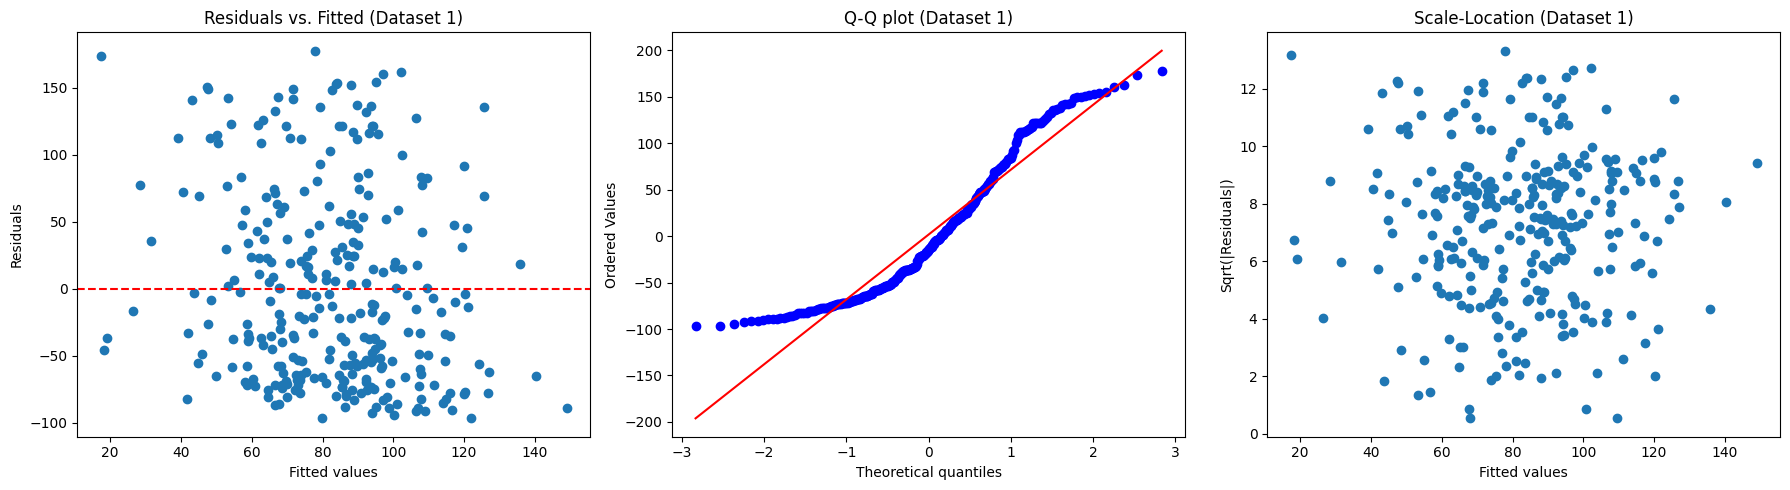

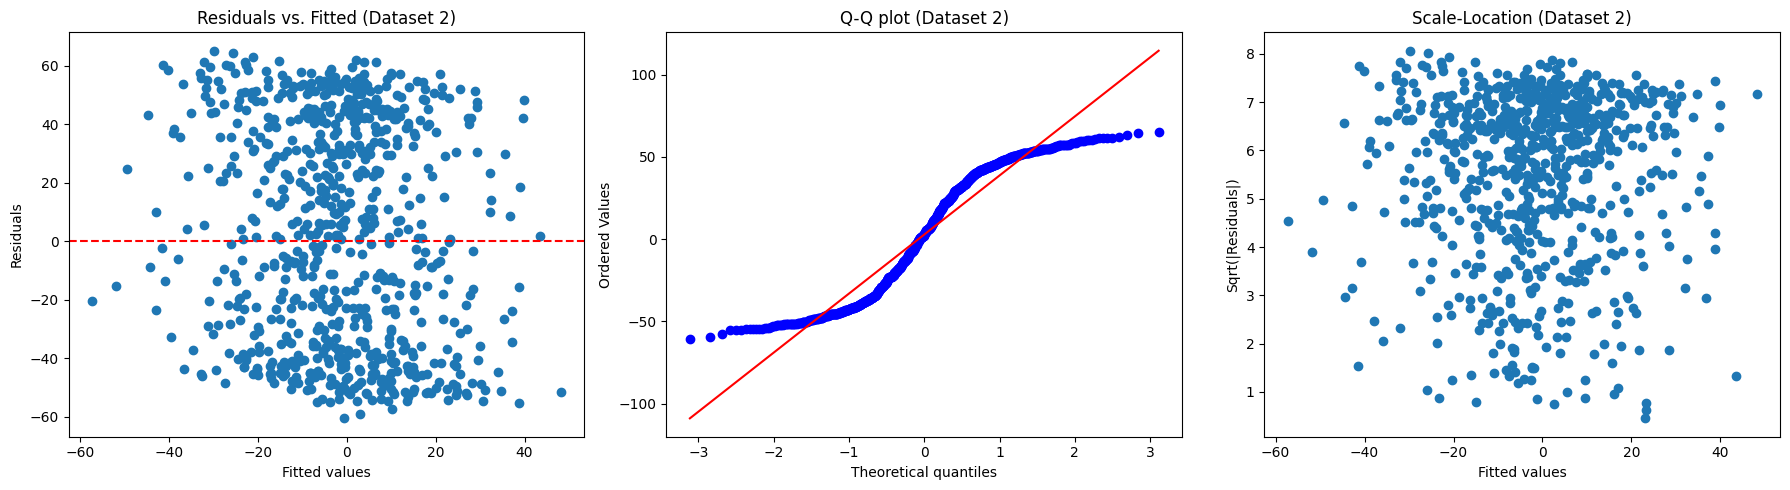

In [5]:
# Function to plot residuals vs. fitted, Q-Q plot, and scale-location plot
def diagnostic_plots(y_test, y_pred, title):
    # Convert to numpy arrays for consistency
    y_test = np.array(y_test).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # Check if y_test and y_pred have the same length
    if y_test.shape != y_pred.shape:
        raise ValueError(f"The shapes of y_test ({y_test.shape}) and y_pred ({y_pred.shape}) do not match.")

    residuals = y_test - y_pred
    fitted = y_pred

    plt.figure(figsize=(18, 5))

    # Residuals vs Fitted
    plt.subplot(1, 3, 1)
    plt.scatter(fitted, residuals)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs. Fitted ({title})')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f'Q-Q plot ({title})')

    # Scale-Location Plot
    plt.subplot(1, 3, 3)
    plt.scatter(fitted, np.sqrt(np.abs(residuals)))
    plt.xlabel('Fitted values')
    plt.ylabel('Sqrt(|Residuals|)')
    plt.title(f'Scale-Location ({title})')

    plt.tight_layout()


# Generate diagnostic plots for  Dataset 1
diagnostic_plots(y1_test, y1_pred, 'Dataset 1')

# Generate diagnostic plots for  Dataset 2
diagnostic_plots(y2_test, y2_pred, 'Dataset 2')
plt.show()

- Those plot confirm our first finding from the RMSE and R^2 scores as the `residuals vs fitted plot` show a non-random pattern indicating that the linear model fit is not capturing all the information in our data.  
- This apply also when analysing the Q-Q plot as our model deviate significantly from the theoretical line especially at the tails which confirm that the residuals here do not follow the normal distribution.

---
---

### Conclusion 1 :

From this first analysis, we can draw the following observations :
- The linear regression is too simplisting to capture the underlying relationships in both datasets. This indicate a poor fit for our dataset. 
- The diagnostic plots suggests that there is a non-linear relationship between the inputs features and our output

### Next step :
To ameliorate our model, we will need now to explore some other non-linear models. This could be done by
- adding polynomial or interaction terms
- variable transformation

Also, as we add some complexity to our model, we will need to consider also the regularisation to avoid overfitting.

----
----

## 2. Loss function
Given that we have an idea about our semiparametric model that we want to fit : $Y_i = X^T_i β + g(T_i) + \epsilon_i$, and that we have as indication on our simulated data that they are sparse, the suggested loss function should be able to :
- capture the difference between the observed responses and the predicted values `y_pred` by our model (classic residual sum of squres - RSS)
- allow a sparse estimation of the $\beta$ coefficient
- allow a penalty term that could control the complexity of the non-linear function `g` to avoid overfitting

Therefore, our loss funciton would have the following form :
$$ L(\beta,g) = RSS + \lambda_1 f_1(\beta) + \lambda_2 f_2(g) $$ 
Where, $\lambda_1$ and $\lambda_2$ are the regularisation factors for the 2 penalties that we  define as : 
- The first term $RSS = \sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2$ where $\hat{Y}_i = X_i^T\beta + g(T_i)$ is the residual sum of squres (RSS) and is capturing the difference between the observed responses and the predicted responses based on our model. So minimising this term will ensure that our model is  well fitted with the predicted response as close as possible to the observed training value.
- The second term $\lambda_1 f_1(\beta)$ : this penalty term need to be defined to capture the sparsity characteristic of our defined input data. For this, an L1 regularisation or the Lasso penalty seems the best fit ( $\lambda_1 \lVert\beta\rVert_1$) as it controls the sparsity of the coefficient $\beta$ and could reduce the number of non-zero coefficients. We will need to find the value of the hyperparameter $\lambda_1$ either by hand or using a cross-validation technique. This penalty (and therefore the value of the hyperparameter) will allow us to control the trade-off between the model fitting and its complexity by reducing the number of predictors 'X_i' when $\lambda_1$ will be higher.
- The third term is the regularisation term $\lambda_2 f_2(g)$ applied to the non-linear function g. This term needs to be defined to allow us to control the complexity of the non-parametric function $g$. As with the previous hyperparameter, $\lambda_2$ will help us to control the trade-off between the fitting of our data and reducing the complexity of the non parametric function $g$ or making it simpler. As example and to avoid overfitting and penalise variability in g, we can define this term as in the example given in ISLP (7.11) [1] by $\int g''(t)^2 dt$. The second derivative corresponds to the amount by which the slope is changing, so such penalty will control the roughness of the g function. In which case, the larger the value of $\lambda$ will be, the smoother g will be.


This gives us the following form for our loss function :
$$ L(\beta,g) = RSS + \lambda_1 \lVert\beta\rVert_1 + \lambda_2 f_2(g) $$ 

---
---

### Conclusion 2 :
We can conclude that our loss function is designed here to allow us to control the bias-variance trade-off between fitting the data with a good accuracy and keeping the prediction model smooth and avoid overfitting.
With this loss function :
- the RSS term ensures a good fit of our model to the training data,
- the L1 regularisation allow us to have the sparsity in line with the simulated data of the linear coefficient, which will help to eliminate the non useful features (feature selection)
- and the regularisation on the non-linear function `g` which will control the complexity of this non parametric component. 
- The value of the hyperaparameters $\lambda_1$ and $\lambda_2$ will need to be defined using cross validation to optimise our model.
----
----

## 3. Minimising the loss function (fitting)
To minimise our loss function we will need to estimate the various parameters of our model that are :
- The coefficients $\beta$ that define the sparse vector of linear regression  
- a non-parametric function $g$

Based on similar technique from both General Additive Models (GAM) and Partial Least Squares (PLS), we can use the backfitting algorithm to estimate those parameters. For this, we can follow the steps below :
- Chose one of the terms of our loss function and take an initial estimate. So let's assume here, that we start by fitting the non-parameteric function g and estimate $\hat{g}$ directly from the data treating `T` the non-linear predictors and `y` (our output). (this correspond to fitting a model $Y_{pred} - X^T β =  \hat{g}(T)$)
- Then, based on this estimated $\hat{g}$, we can minimise our loss function with respect to $\beta$, by trying to fit the linear term of our model. This represent a lasso linear regression on the remaining partial residual from the previous step ( here we are fitting the model $Y_{pred} - \hat{g}(T) =  X^T \beta$). 
$$ \hat{\beta} = \text{argmin}_{\beta} \sum_{i=1}^n (Y_i - X_i\beta - \beta{g(T_i)})^2 + \lambda_1 \lVert \beta \rVert_1  $$

- Then we can do the same step by using now the estimated $\hat{\beta}$ and updating the value of $\hat{g}$ by minimising the loss function with respect to g this time, considering the other term (the linear function) as fixed. This could be seen as fitting a non-linear model to the partial residual $Y_{pred} - X^T \hat{\beta} =  g(T)$. Then we have that : 
$$ \hat{g} = \text{argmin}_g \sum_{i=1}^n (Y_i - X_i\beta - \beta{g(T_i)})^2 + \lambda_2 f_2(g)  $$
- We repeat the process iteratively until either we converge or after a defined number of iteration.

The initiatlisation of the process could be similarly done by either of the term. This shouldn't impact the backfitting process. 

**Pseudocode** :

>1. Initialise a first estimate of $\hat{g}$
>2. Repeat until ( (nmax iteration reached) or (convergence reached) )
>>>    2.1. Fit the value of $\hat{\beta}$ by considering $\hat{g}$ as fixed and regressing on X with the L1 penalty  \
>>>    2.2. Fit the value of $\hat{g}$ by considering $\hat{\beta}$ as fixed and regressing on T with the corresponding regularisation parameter $\lambda_2$


Noting that the convergence is reached when the loss function change is less or equal to a predefined threshold.

---
---

## 4. Solution Code :

For our code, we will use the same logic as in the `sklearn`, a good starting structure is taken from the official documentation here :
- [Developing scikit-learn estimators](https://scikit-learn.org/stable/developers/develop.html)

- [Examples developing Estimators Sklearn](https://scikit-learn.org/stable/auto_examples/developing_estimators/sklearn_is_fitted.html#sphx-glr-auto-examples-developing-estimators-sklearn-is-fitted-py)

We can see that we can define a `class` based on the strcucture of `CustomEstimator` with functions :
- `__init__` : the method that initiate the regressor. The arguments accepted by __init__ should all be keyword arguments with a default value. The arguments should all correspond to hyperparameters describing the model, in our case this corresponds to :
  - `g_estimator` which is the Estimator object for the non-parametric function `g` part of the model
  - `linear_estimator` which is the Estimator object for the linear function part of the model
  - `maxiter` which is the maximum iteration for the backfitting algorithm
  - `tol` which is the tolerance for the backfitting algorithm
- `__sklearn_is_fitted__` : method recommended by sklearn documentation to check if the regressor was fitting or not 
- `fit` : method that will take the training data as arguments and that will estimate the parameters in our model (here $\beta$ and $g$) to fit the model
- `predict` : method to be used after the fitting step to predict the output based on the inputs X, T
- `score` : method that could be used to score the regressor



In [6]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler,SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score
from sklearn.datasets import make_regression
import numpy as np
import matplotlib.pyplot as plt

class CustomNonLinearEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, g_estimator=SplineTransformer(), linear_estimator=LinearRegression(),maxiter=1000,tol=1e-4,nb_T_input=1):
        """ An hybrid estimator ombining linear regression with a non-linear 
        estimator for g :
        Y = X.T Beta + g(T).

        Estimator based on the sklearn template from : 
        https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/_template.py

        Parameters
        ----------
        g_estimator : sklearn Estimator object, could be a Pipeline, 
        default=SplineTransformer()
            An estimator object implementing fit and predict for the non-linear 
            part.
        linear_estimator : sklearn Estimator object, could be a Pipeline, 
        default=LinearRegression()
            An estimator object implementing fit and predict for the linear part.
        maxiter : integer, default=1000
            The number of iteration in our model for the backfitting algorith
        tol : float, default=1e-4
            the tolerance for the convergence stopping criteria for 
            the backfitting algorithm 
        nb_T_input, integer, default=1
            the number of input to be used as part of the non-parametric 
            function of our model.
            For this tutorial, we will only test the case where we 
            have only T with 1 dimension    
        Examples
        --------
        >>> from package_name import CustomNonLinearEstimator
        >>> g_estimator = Pipeline([
        >>>       ('scaler', StandardScaler()),  # First, scale the data
        >>>       ('Spline', SplineTransformer(n_knots=10, degree=3)), 
        >>>       ('regressor', LinearRegression())  # Then, apply linear regression
        >>>       ])
        >>> linear_estimator = Pipeline([
        >>>       ('scaler', StandardScaler()),  # First, scale the data
        >>>       ('Spline', Lasso(alpha=lambda_1))
        >>>       ])
        >>> estimator = CustomNonLinearEstimator(g_estimator=g_estimator, 
        >>> linear_estimator=linear_estimator)
        >>> estimator.fit([X,T], y)
        """
        self.g_estimator = g_estimator
        self.linear_estimator = linear_estimator
        self.maxiter=maxiter
        self.tol=tol
        self.nb_T_input=nb_T_input
        self.fitted = False

    def fit(self, data, y):
        """
        Fit the our hybrid linear and non-parametric model.

        Parameters
        ----------
        X : dataframe shape (n_samples, n_X_features)
            The training input samples for the linear regression part of the model
        T : dataframe shape (n_samples,1)
            The training input samples for the non-parameteric part of the model 
            (the temporal part).
        y : dataframe, shape (n_samples,) 
            The target values (real numbers).

        Returns
        -------
        self : object
            Returns self.
        """

        X = data.iloc[:,:-self.nb_T_input]
        T = data.iloc[:,-self.nb_T_input:]
        n,p = X.shape
        # Fit the non-linear model g(T)
        i = 1
        loss_tab = []

        # Inititalisation of the loss function
        beta = np.zeros(p)
        g_pred = np.mean(T,axis=0)[0]
        y_pred = (np.dot(X,beta)).reshape(-1,1) + g_pred.reshape(-1,1)
        loss_0 = np.mean((y- y_pred)**2,axis=0)[0]
        loss_tab.append(loss_0)
        while (i < self.maxiter): 
            self.g_estimator.fit(T, y)
            g_pred = self.g_estimator.predict(T)
            
            # Update y by subtracting the predicted non-linear component
            y_linear = y - g_pred.reshape(-1,1)
            
            # Fit the linear model to the residuals
            self.linear_estimator.fit(X, y_linear)
            
            
            # Calculating the new loss function 
            beta = self.linear_estimator.named_steps['Lasso'].coef_
            y_pred = (np.dot(X,beta)).reshape(-1,1) + g_pred.reshape(-1,1)
            loss_i = np.mean((y - y_pred)**2,axis=0)[0]
            loss_tab.append(loss_i)

            # We check the tolerance only when we have 2 calculated 
            # loss different from the
            # loss calculated randomly at initialisation 
            # (to avoid any case were the first )
            # calcualted loss is same as the initialisation loss
            if (i>1):
                delta_loss = np.abs(loss_tab[i-1] - loss_tab[i-2])
                # if the difference of the loss is less than the self.tol we stop the loop
                if (delta_loss<self.tol):
                    break      
            i = i+1
        self.beta_ = self.linear_estimator.named_steps['Lasso'].coef_
        self.g_pred_ = g_pred
        self.fitted = True
        return self
    
    def predict(self, data):
        """
        Predict using the hybrid linear and non-parametric model.
        
        Parameters 
        ----------
        X : dataframe shape (n_samples, n_X_features)
            The  input samples for the prediction for the linear 
            regression part of the model
        T : dataframe shape (n_samples,1)
            The  input samples for the prediction for the non-parameteric 
            part of the model (the temporal part).

        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns an array of ones.
        """
        
        if not self.fitted:
            raise ValueError("Model must be fitted before predicting.")
        X = data.iloc[:,:-self.nb_T_input]
        T = data.iloc[:,-self.nb_T_input:]
        # Predict with the non-linear model g(T)
        g_pred_ = self.g_estimator.predict(T)
        #print("g_pred : ",g_pred.shape)
        
        # Predict with the linear model and add the predictions
        linear_pred_ = self.linear_estimator.predict(X)
        #print("linear_pred : ",linear_pred.shape)
        y_pred_ = linear_pred_.reshape(-1,1) + g_pred_.reshape(-1,1) 
        #print("y_pred : ",y_pred.shape)
        return y_pred_
    
    def score(self,data,y):
        """
        Return the coefficient of determination R^2 of the prediction.
        
        :param X: Feature matrix for the linear component.
        :param T: Feature matrix for the non-linear component.
        :param y: True values for prediction.
        :return: R^2 score
        """
        if not self.fitted:
            raise ValueError("Model must be fitted before predicting.")
        
        y_pred = self.predict(data)
        return r2_score(y, y_pred)

    def __sklearn_is_fitted__(self):
        """
        Check fitted status and return a Boolean value.
        """
        return hasattr(self, "_is_fitted") and self._is_fitted

Now that we defined our estimator `CustomNonLinearEstimator`, we will test it on our dataset 1 and 2.
For the test, we have to select some values for the parameters of our estimators :
- the L1 regularisation for the Lasso regression : value chosen is 0.01, `alpha=0.01`
- Number of knots and degrees of freedom for the Spline Transformer : value chosen here are `n_knots=10` and `degree=3`
- We limited the number of iteration for the backfitting to 100 (`maxiter=100`)

In [7]:
# Defining the parameters for our testing
np.random.seed(12) 
lambda_1 = 0.01 # Hyperparameter for the L1 regularisation 
Spline_knots = 10 # Number of Knots for the Spline Transformer
Spline_degree = 3 # Number of degree for the Spline Transformer



We then define our estimator that we will need to initaite the estimator `CustomNonLinearEstimator`.
For each estimator we defined a pipine as following :
- `g_estimator` : pipeline for estimation of the function g, where we scaled our data (`StandardScaler()`), then applied the Spline estimator (`SplineTranformer()`) and applied a linear regression (`LinearRegression()`)
- `linear_estimator` : pipeline for the linear estimation of the parameters `$\beta$` using the sparse Lasso regression, where we also scaled our data (`StandardScaler()`) and then applied the Lasso regression (`Lasso()`)

In [8]:

# Define a non-linear estimator for g using polynomial features and linear regression
g_estimator_1 = Pipeline([
    ('scaler', StandardScaler()),  # First, scale the data
    ('Spline', SplineTransformer(n_knots=Spline_knots, degree=Spline_degree)),
    ('regressor', LinearRegression())  # Then, apply linear regression
])

linear_estimator_1 = Pipeline([
    ('scaler', StandardScaler()),  # First, scale the data
    ('Lasso', Lasso(alpha=lambda_1))
])

# Define a non-linear estimator for g using polynomial features and linear regression
g_estimator_2 = Pipeline([
    ('scaler', StandardScaler()),  # First, scale the data
    ('Spline', SplineTransformer(n_knots=Spline_knots, degree=Spline_degree)),
    ('regressor', LinearRegression())  # Then, apply linear regression
])

linear_estimator_2 = Pipeline([
    ('scaler', StandardScaler()),  # First, scale the data
    ('Lasso', Lasso(alpha=lambda_1))
])


Now we can initiate our Estimator by calling the class that we created and its methods `fit` and `predict` 

In [9]:

# Initialize and fit the semi-parametric regressor
model_1 = CustomNonLinearEstimator(g_estimator=g_estimator_1, linear_estimator=linear_estimator_1,maxiter=100)
model_1.fit(XT1_train, y1_train)


model_2 = CustomNonLinearEstimator(g_estimator=g_estimator_2, linear_estimator=linear_estimator_2,maxiter=100)
model_2.fit(XT2_train, y2_train)


# Predict on new data
y1_pred_test = model_1.predict(XT1_test) # prediction using our model on the test dataset 1
y1_pred_train = model_1.predict(XT1_train) # prediction using our model on the train dataset 1
y2_pred_test = model_2.predict(XT2_test) # prediction using our model 2 on the test  dataset 2
y2_pred_train = model_2.predict(XT2_train) # prediction using our model 2 on the train dataset 2


We can evaluate our model :

In [10]:
evaluate_model(y1_test,y1_pred_test,"Dataset 1 - Metrics for a CustomNonLinearRegressor")
evaluate_model(y2_test,y2_pred_test,"Dataset 2 - Metrics for a CustomNonLinearRegressor")

Dataset 1 - Metrics for a CustomNonLinearRegressor
    R^2 Score: 1.00
    MSE: 3.82
    RMSE: 1.95
    MAE: 1.54
Dataset 2 - Metrics for a CustomNonLinearRegressor
    R^2 Score: -4.02
    MSE: 7503.11
    RMSE: 86.62
    MAE: 78.28


We see that our model with the selected hyperparameters works well for the dataset 1 but not in the dataset 2.
By comparing both dataset, we can understand the issue with the second dataset which seems to have a periodic pattern. For this, we will try to adapt the `model_2` slightly by changing the our estimator of the non-parametric function $\hat{g}$. One solution could be by using the pararmeter `extrapolation='periodic'` in the `SplineTransformer()` estimator and increasing the number of knots. 



In [13]:
# Defining new parameter for our model 2 the parameters for our testing
Spline_knots_2 = 15 # Number of Knots for the Spline Transformer

# Define a non-linear estimator for g using polynomial features and linear regression
g_estimator_2_periodic = Pipeline([
    ('scaler', StandardScaler()),  # First, scale the data
    ('Spline', SplineTransformer(n_knots=Spline_knots_2, degree=Spline_degree,extrapolation='periodic')),
    ('regressor', LinearRegression())  # Then, apply linear regression
])



model_2 = CustomNonLinearEstimator(g_estimator=g_estimator_2_periodic, linear_estimator=linear_estimator_2,maxiter=100)
model_2.fit(XT2_train, y2_train)
y2_pred_test = model_2.predict(XT2_test)
y2_pred_train = model_2.predict(XT2_train)

evaluate_model(y2_test,y2_pred_test,"Dataset 2 - Metrics for a CustomNonLinearRegressor")

Dataset 2 - Metrics for a CustomNonLinearRegressor
    R^2 Score: 0.98
    MSE: 29.26
    RMSE: 5.41
    MAE: 4.45


We can see that this 2nd model with the periodicity extrapolation seems to fit better to our dataset 2

Let's now see some plots to check that our model fitted well our datasets :

### 4.c
We start by looking to some figures of our model on both `dataset1` and `dataset2` :

- First we look at the $\hat{\beta}_{model_1}$ and $\hat{\beta}_{model_2}$ fitted on the 2 datasets : we can see that only 4 coefficients are non zero. This is inline with our first assumption of a sparse $\beta$ values

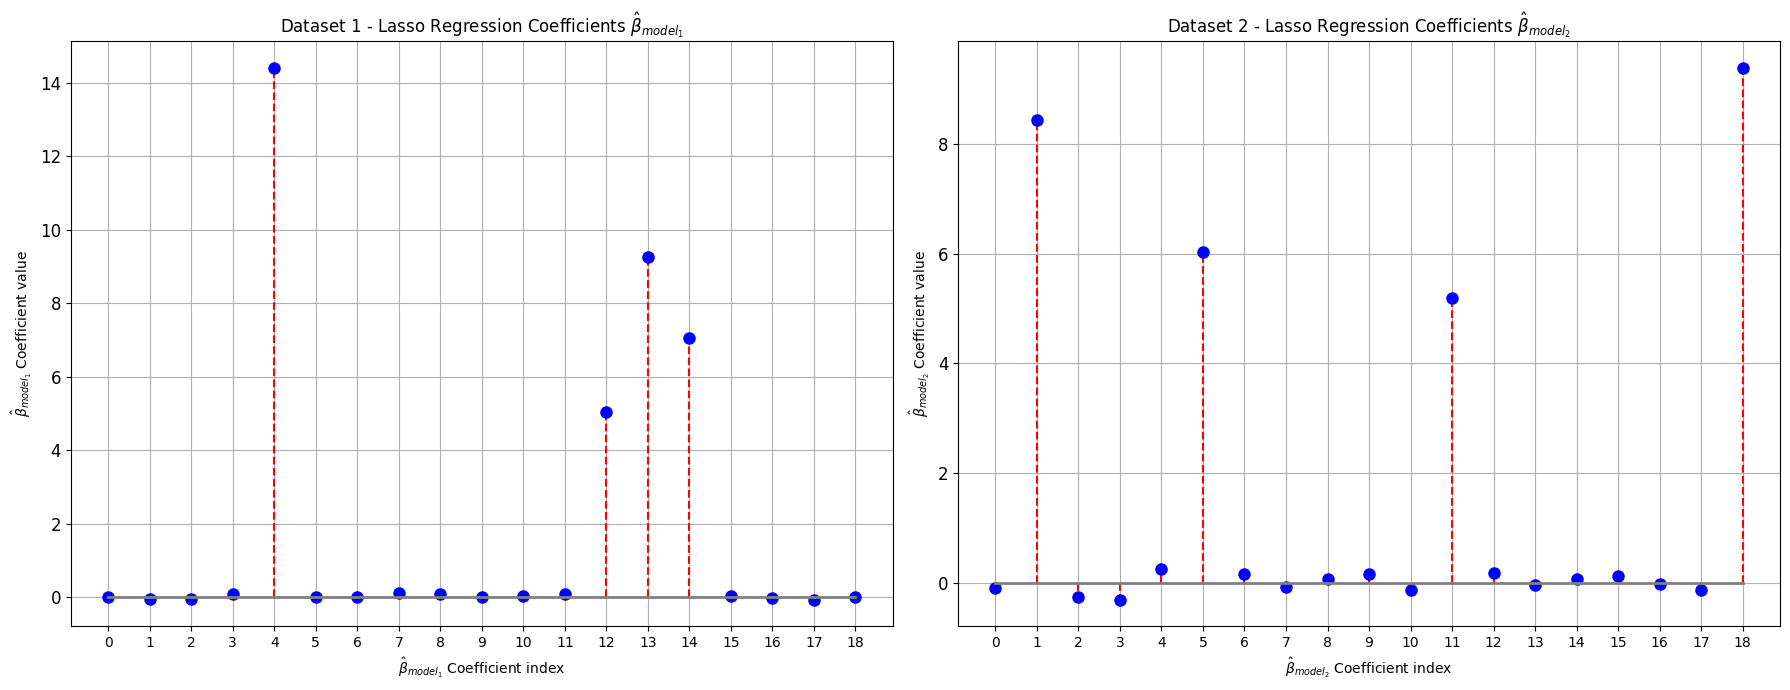

In [14]:
beta_1 = model_1.beta_
beta_2 = model_2.beta_

# Create the stem plot
fig, axes = plt.subplots(1, 2, figsize=(18, 7))  # 1 row, 2 columns

(markerline, stemlines, baseline) = axes[0].stem(range(len(beta_1)), beta_1,basefmt="gray")
plt.setp(markerline, color='b', markersize=8)  # Blue markers with size 8
plt.setp(stemlines, color='r', linestyle='--')  # Red stems with dashed lines
plt.setp(baseline, color='gray', linewidth=2)  # Gray baseline with width 2

axes[0].set_xlabel(r'$\hat{\beta}_{model_1}$ Coefficient index')
axes[0].set_ylabel(r'$\hat{\beta}_{model_1}$ Coefficient value')
axes[0].grid(True)  # Add grid lines for better readability
axes[0].set_xticks(range(19))   # create xlabel using only the 19 integers 0 to 18
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title(r"Dataset 1 - Lasso Regression Coefficients $\hat{\beta}_{model_1}$")

(markerline, stemlines, baseline) = axes[1].stem(range(len(beta_2)), beta_2,basefmt="gray")
plt.setp(markerline, color='b', markersize=8)  # Blue markers with size 8
plt.setp(stemlines, color='r', linestyle='--')  # Red stems with dashed lines
plt.setp(baseline, color='gray', linewidth=2)  # Gray baseline with width 2
axes[1].set_xlabel(r'$\hat{\beta}_{model_2}$ Coefficient index')
axes[1].set_ylabel(r'$\hat{\beta}_{model_2}$ Coefficient value')
axes[1].grid(True)  # Add grid lines for better readability
axes[1].set_xticks(range(19))  # create xlabel using only the 19 integers 0 to 18
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title(r"Dataset 2 - Lasso Regression Coefficients $\hat{\beta}_{model_2}$")
plt.tight_layout()
plt.show()

- Now we can plot the training data and the predicted against time 

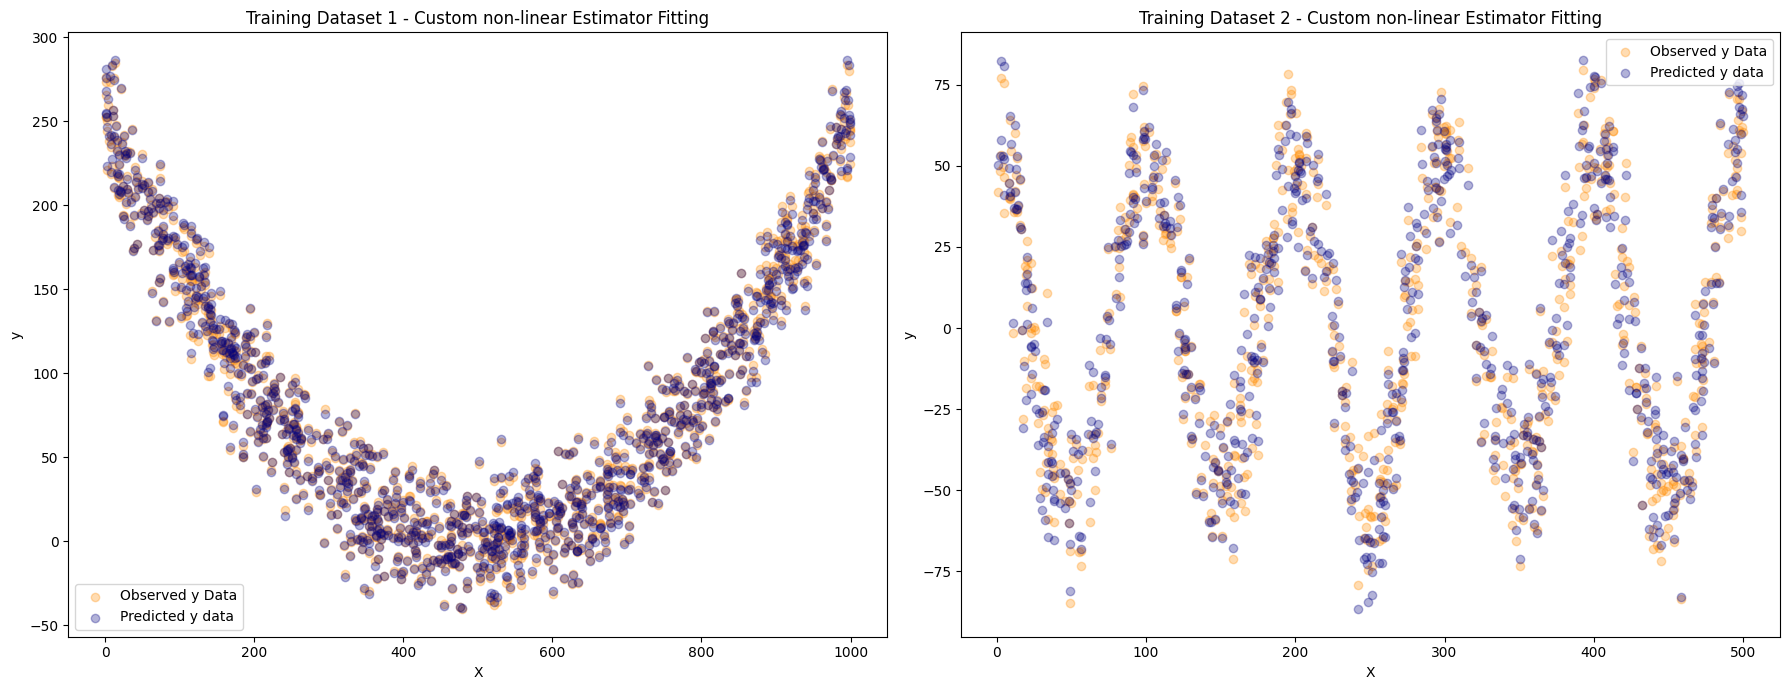

In [15]:
# First we extract the T1 features input from our combined training dataframe 

T1_train = XT1_train.iloc[:,-1:]
T2_train = XT2_train.iloc[:,-1:]
fig, axes = plt.subplots(1, 2, figsize=(18, 7))  # 1 row, 2 columns

# Plot the data and the model predictions
axes[0].scatter(T1_train, y1_train, color='darkorange', label='Observed y Data',alpha=0.3)
axes[0].scatter(T1_train, y1_pred_train, color='navy',label="Predicted y data",alpha=0.3)
axes[0].set_xlabel('X')
axes[0].set_ylabel('y')
axes[0].set_title('Training Dataset 1 - Custom non-linear Estimator Fitting')
axes[0].legend()

# Plot the data and the model predictions
axes[1].scatter(T2_train, y2_train, color='darkorange', label='Observed y Data',alpha=0.3)
axes[1].scatter(T2_train, y2_pred_train, color='navy',label="Predicted y data",alpha=0.3)
axes[1].set_xlabel('X')
axes[1].set_ylabel('y')
axes[1].set_title('Training Dataset 2 - Custom non-linear Estimator Fitting')
axes[1].legend()
plt.tight_layout()
plt.show()


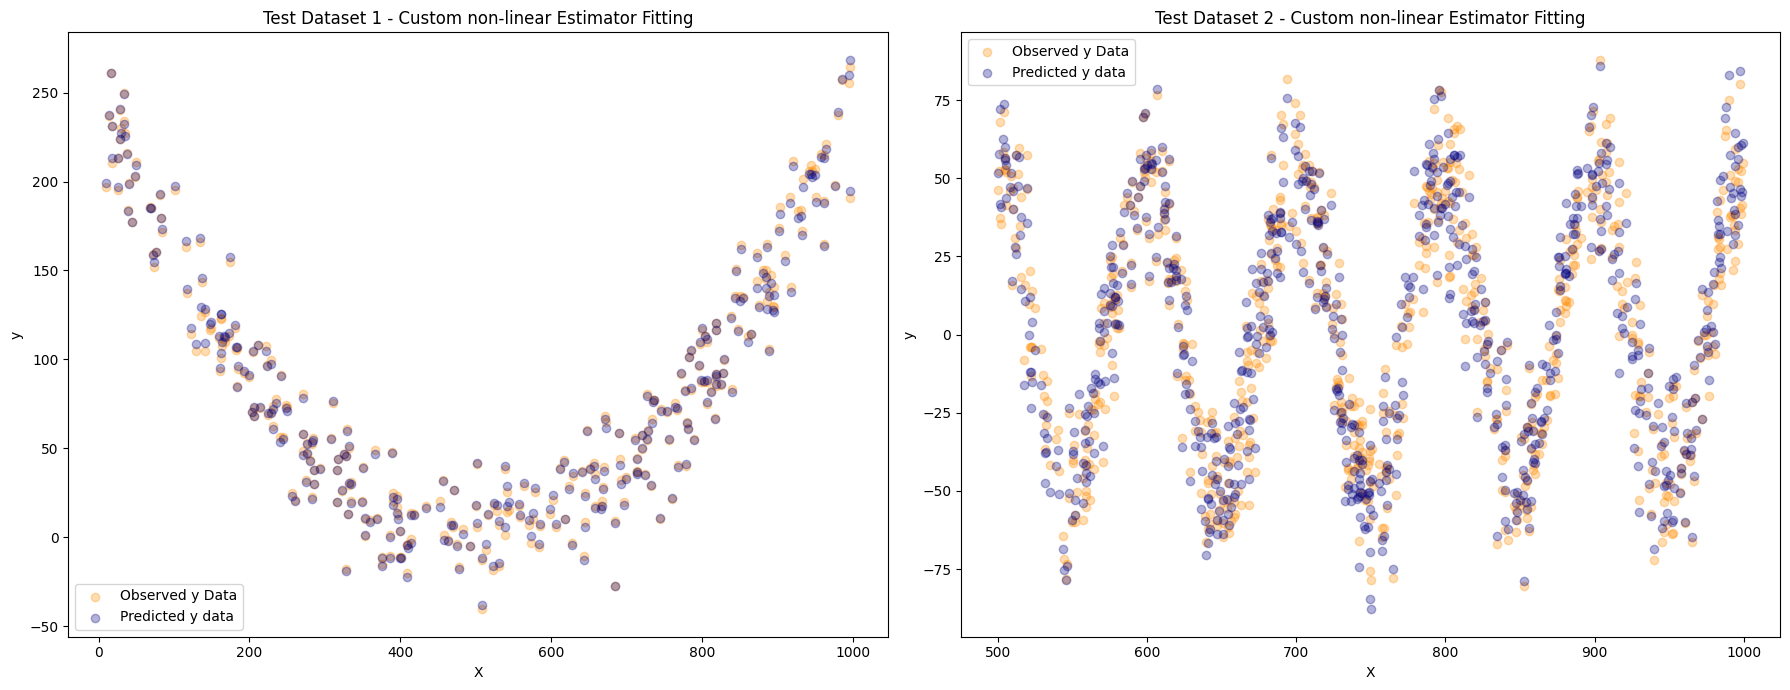

In [16]:
# First we extract the T1 features input from our combined test dataframe

T1_test = XT1_test.iloc[:,-1:]
T2_test = XT2_test.iloc[:,-1:]

fig, axes = plt.subplots(1, 2, figsize=(18, 7))  # 1 row, 2 columns

# Plot the data and the model predictions
axes[0].scatter(T1_test, y1_test, color='darkorange', label='Observed y Data',alpha=0.3)
axes[0].scatter(T1_test, y1_pred_test, color='navy',label="Predicted y data",alpha=0.3)
axes[0].set_xlabel('X')
axes[0].set_ylabel('y')
axes[0].set_title('Test Dataset 1 - Custom non-linear Estimator Fitting')
axes[0].legend()

# Plot the data and the model predictions
axes[1].scatter(T2_test, y2_test, color='darkorange', label='Observed y Data',alpha=0.3)
axes[1].scatter(T2_test, y2_pred_test, color='navy',label="Predicted y data",alpha=0.3)
axes[1].set_xlabel('X')
axes[1].set_ylabel('y')
axes[1].set_title('Test Dataset 2 - Custom non-linear Estimator Fitting')
axes[1].legend()
plt.tight_layout()
plt.show()


We can see from the previous 4 plots that our model estimate a good fit when we see the blue and yellow point (the blue being the predicted data using our model).
Another good figure would be to plot on the same plot the training data and the test data and see how our model does. 

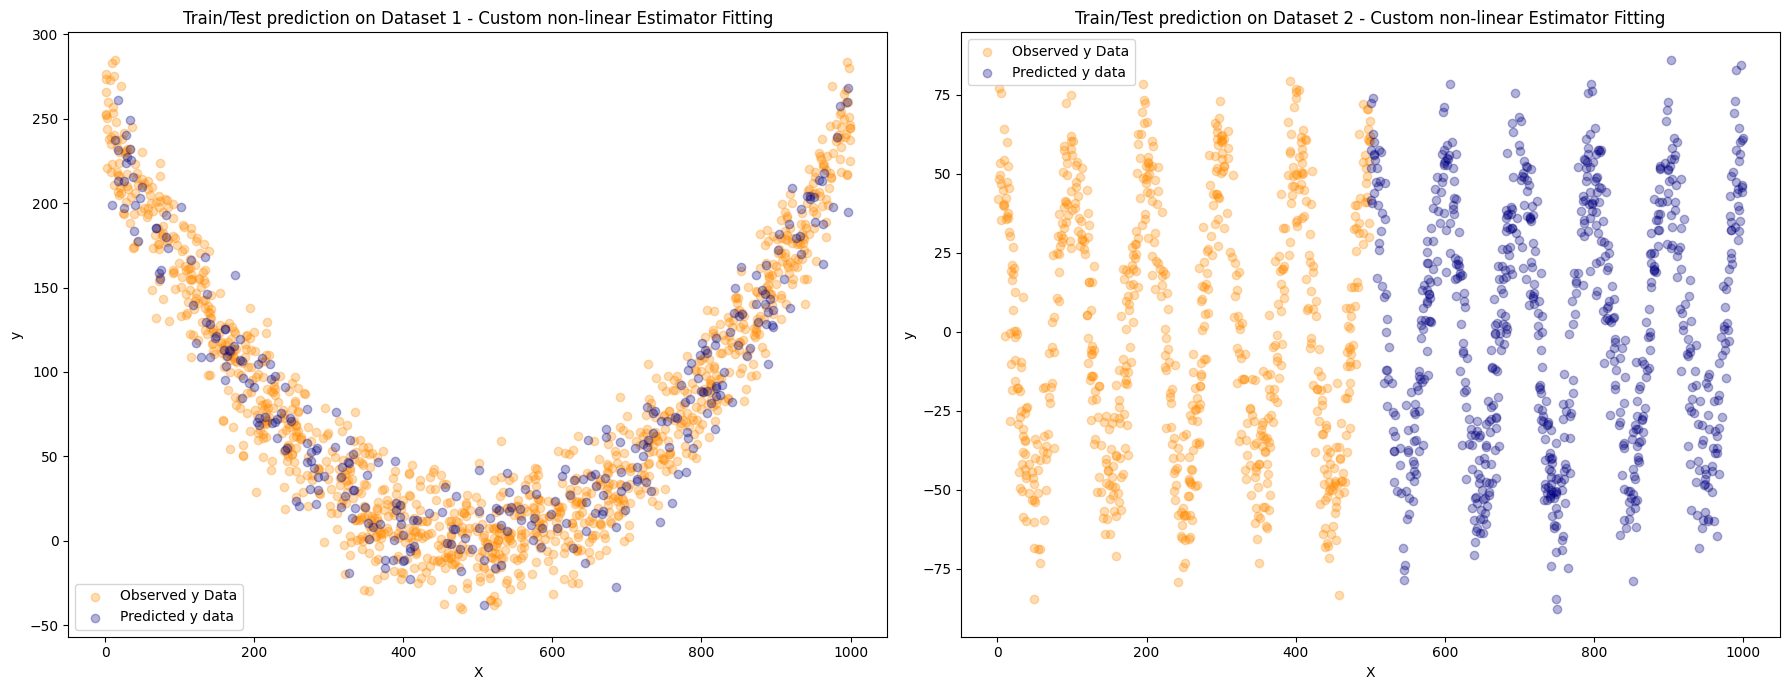

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))  # 1 row, 2 columns

# Plot the data and the model predictions
axes[0].scatter(T1_train, y1_train, color='darkorange', label='Observed y Data',alpha=0.3)
axes[0].scatter(T1_test, y1_pred_test, color='navy',label="Predicted y data",alpha=0.3)
axes[0].set_xlabel('X')
axes[0].set_ylabel('y')
axes[0].set_title('Train/Test prediction on Dataset 1 - Custom non-linear Estimator Fitting')
axes[0].legend()

# Plot the data and the model predictions
axes[1].scatter(T2_train, y2_train, color='darkorange', label='Observed y Data',alpha=0.3)
axes[1].scatter(T2_test, y2_pred_test, color='navy',label="Predicted y data",alpha=0.3)
axes[1].set_xlabel('X')
axes[1].set_ylabel('y')
axes[1].set_title('Train/Test prediction on Dataset 2 - Custom non-linear Estimator Fitting')
axes[1].legend()
plt.tight_layout()
plt.show()

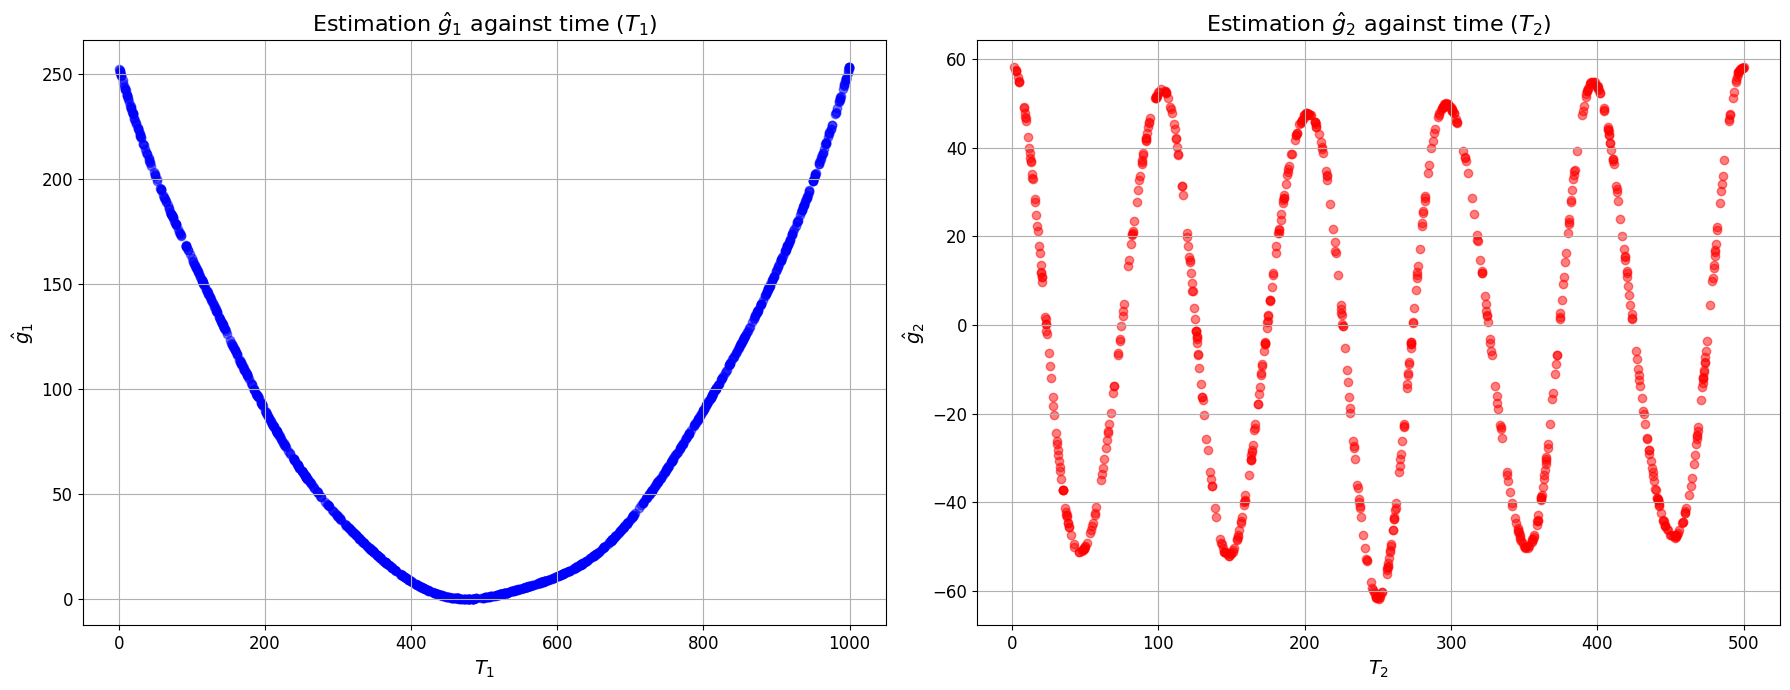

In [18]:
g_pred_1 = model_1.g_pred_
g_pred_2 = model_2.g_pred_

fig, axes = plt.subplots(1, 2, figsize=(18, 7))  # 1 row, 2 columns


# Plot for the first predictor g_1
axes[0].scatter(T1_train, g_pred_1, alpha=0.5, color='blue') 
axes[0].set_xlabel(r"$T_1$", fontsize=14)
axes[0].set_ylabel(r"$\hat{g}_1$", fontsize=14)
axes[0].set_title(r"Estimation $\hat{g}_1$ against time ($T_1$)", fontsize=16)
axes[0].grid(True)
axes[0].tick_params(axis='both', labelsize=12)  # Set the font size of ticks

# Plot for the second predictor g_2
axes[1].scatter(T2_train, g_pred_2, alpha=0.5, color='red') 
axes[1].set_xlabel(r"$T_2$", fontsize=14)
axes[1].set_ylabel(r"$\hat{g}_2$", fontsize=14)
axes[1].set_title(r"Estimation $\hat{g}_2$ against time ($T_2$)", fontsize=16)
axes[1].grid(True)
axes[1].tick_params(axis='both', labelsize=12)  

# Adjust layout for better display
plt.tight_layout()
plt.show()

We can see here also have some observation, mainly in relatition to the good fit of the $\hat{g}$ estimator.
- in the case of dataset1, the predicted output (in blue) seems to follow the general shape of the dataset
- the second plot also shows that our model has a good fit with the periodic behaviour of the dataset 2 and it seems that our model have a good  generalisation result.


Now we will have a look to the training/test errors by looking to the following metrics :
- Mean squared errors
- Root mean squared errors
- Mean absolute error

In [19]:
print("\n-----------------------------")
print("Dataset 01")
print("-----------------------------")
evaluate_model(y1_train,y1_pred_train,"Dataset 1 - Training Errors")
evaluate_model(y1_test,y1_pred_test,"Dataset 1 - Test Errors")
print("\n-----------------------------")
print("Dataset 02")
print("-----------------------------")
evaluate_model(y2_train,y2_pred_train,"Dataset 2 - Training Errors")
evaluate_model(y2_test,y2_pred_test,"Dataset 2 - Test Errors")


-----------------------------
Dataset 01
-----------------------------
Dataset 1 - Training Errors
    R^2 Score: 1.00
    MSE: 3.73
    RMSE: 1.93
    MAE: 1.56
Dataset 1 - Test Errors
    R^2 Score: 1.00
    MSE: 3.82
    RMSE: 1.95
    MAE: 1.54

-----------------------------
Dataset 02
-----------------------------
Dataset 2 - Training Errors
    R^2 Score: 0.99
    MSE: 16.36
    RMSE: 4.04
    MAE: 3.35
Dataset 2 - Test Errors
    R^2 Score: 0.98
    MSE: 29.26
    RMSE: 5.41
    MAE: 4.45


We can see that our model still doing well in both training and test datasets as the error increased slightly between the train and tests errors :
- dataset 1 : the RMSE increased from 1.93 to 1.95
- dataset 2 : the RMSE increased from 4.04 to 5.41

As we can see also, due to the complexity of the dataset 2 with the periodicity behavior, the error on the dataset 2 increased more than for dataset 1. This is excpected as the generalisation with the dataset 2 is more difficult. Also, at this level, the tuning of the hyperparameters for the Spline and Lasso were done by hand, we may be able to increase the accuracy of our model by using a cross-validation to find better hyperparameters. 

---
---

## 5. Cross-validation :

---
---

## 6. Gaussian Porcess (GP):
Now that we fitted a good model on both dataset 1 and 2 using Lasso  regressor and an Spline regressor. We will test another alternative to the splines which is the Gaussian Process (GP)

---
---

## 7. Conclusion :

----
[1] James, G.; Witten, D.; Hastie, T.; Tibshirani, R. & Taylor, J. (2023), An Introduction to Statistical Learning with Applications in Python , Springer , Cham .